In [33]:
import matplotlib.pyplot as plt
import matplotlib.cbook as cbook
import numpy as np
import pandas as pd
from imblearn.ensemble import EasyEnsembleClassifier
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_validate
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from xgboost.sklearn import XGBClassifier

from util import load_data, fdr
from ensemble import MakeEnsemble

pd.set_option('display.max_rows', 100)

In [2]:
x_train, _, x_oot, y_train, _, y_oot = load_data('var_30.csv', test_size=0)
x_train.head()
x_train = x_train.to_numpy()

,ssn_count_3,fulladdress_count_0,address_count_0,name_dob_count_3,homephone_count_14,name_dob_count_7,name_day_since,ssn_firstname_count_0_by_14,name_count_7,fulladdress_homephone_count_0_by_14,...,ssn_count_0_by_14,ssn_firstname_count_7,ssn_count_7,fulladdress_count_1_by_14,fulladdress_homephone_count_7,ssn_name_dob_count_7,name_count_14,ssn_firstname_count_0_by_30,ssn_lastname_count_0_by_30,ssn_count_14
173786,-0.047591,-0.041351,-0.042158,-0.046415,0.708788,-0.055801,0.598116,0.123528,-0.115648,0.120387,...,0.124781,-0.057185,-0.058092,0.123861,-0.057263,-0.055635,-0.159376,0.171472,0.171458,-0.072421
109156,-0.047591,-0.041351,-0.042158,-0.046415,0.135423,-0.055801,0.598116,0.123528,-0.115648,0.120387,...,0.124781,-0.057185,-0.058092,0.123861,-0.057263,-0.055635,-0.159376,0.171472,0.171458,-0.072421
114695,-0.047591,-0.041351,-0.042158,-0.046415,1.282153,-0.055801,0.598116,0.123528,-0.115648,0.120387,...,0.124781,-0.057185,-0.058092,0.123861,-0.057263,-0.055635,-0.159376,0.171472,0.171458,-0.072421
610552,-0.047591,-0.041351,-0.042158,-0.046415,-1.011308,-0.055801,0.598116,0.123528,-0.115648,0.120387,...,0.124781,-0.057185,-0.058092,0.123861,-0.057263,-0.055635,-0.159376,0.171472,0.171458,-0.072421
748632,-0.047591,-0.041351,-0.042158,-0.046415,1.282153,-0.055801,0.598116,0.123528,-0.115648,0.120387,...,0.124781,-0.057185,-0.058092,0.123861,-0.057263,-0.055635,-0.159376,0.171472,0.171458,-0.072421


In [3]:
def add_score(score, label, train_scores, test_scores):
    train_scores.append(score['train_score'])
    test_scores.append(score['test_score'])
    labels.append(label)
    print(np.mean(score['test_score']))

In [4]:
labels = []
train_scores = []
test_scores = []

In [5]:
# Logistic regression
lr = LogisticRegression(max_iter=1000, 
                        C=1, 
                        class_weight='balanced').fit(x_train, y_train)
score = cross_validate(lr, x_train, y_train, 
                       scoring=fdr, cv=10, return_train_score=True)
add_score(score, 'LR', train_scores, test_scores)

0.5286786618021867


In [6]:
# Decision tree
dt = DecisionTreeClassifier(ccp_alpha=1e-06, 
                            max_depth=20,
                            min_samples_leaf=64, 
                            class_weight=None,
                            criterion='gini')
score = cross_validate(dt, x_train, y_train, 
                       scoring=fdr, cv=10, n_jobs=8, return_train_score=True)
add_score(score, 'DT', train_scores, test_scores)

0.5468096594965202


In [13]:
# Random forest
rf = RandomForestClassifier(n_estimators=300,
                            max_depth=17, 
                            max_features=10,
                            ccp_alpha=1e-6, 
                            n_jobs=8).fit(x_train, y_train)
score = cross_validate(rf, x_train, y_train, 
                       scoring=fdr, cv=10, return_train_score=True)
add_score(score, 'RF', train_scores, test_scores)

0.5499490414321256


In [14]:
# Boosted tree
bt = XGBClassifier(n_estimators=200,
                   max_depth=5,
                   learning_rate=0.05,
                   subsample=0.5,
                   verbose=3, n_jobs=8).fit(x_train, y_train)
score = cross_validate(bt, x_train, y_train, 
                       scoring=fdr, cv=10, return_train_score=True)
add_score(score, 'BT', train_scores, test_scores)

0.5495131216413671


In [27]:
# Random forest with random under sampling
rf = RandomForestClassifier(n_estimators=100,
                            max_depth=17, 
                            max_features=10,
                            ccp_alpha=1e-6, 
                            n_jobs=4)
ee = EasyEnsembleClassifier(n_estimators=50,
                            base_estimator=rf,
                            sampling_strategy='not minority',
                            n_jobs=2,
                            verbose=0).fit(x_train, y_train)
score = cross_validate(ee, x_train, y_train, 
                       scoring=fdr, cv=10, return_train_score=True)
add_score(score, 'RF_US', train_scores, test_scores)

0.5487285419622163


In [57]:
# Decision tree with Random undersample to 10% and then SMOTE
score = {'train_score': [], 'test_score': []}
for _ in range(10):
    x, x_test, y, y_test = train_test_split(x_train, y_train, test_size=0.1)
    dt = DecisionTreeClassifier(ccp_alpha=1e-06, max_depth=20, min_samples_leaf=64, class_weight=None, criterion='gini')
    me = MakeEnsemble(dt, [RandomUnderSampler(sampling_strategy=0.1), SMOTE()],
                      n_estimators=50, n_jobs=8, verbose=0)
    me.fit(x, y)
    score['train_score'].append(fdr(me, x, y))
    score['test_score'].append(fdr(me, x_test, y_test))

score['train_score'] = np.asarray(score['train_score'])
score['test_score'] = np.asarray(score['test_score'])
add_score(score, 'DT_US_SMOTE', train_scores, test_scores)

0.5473253081504932


In [69]:
result = pd.DataFrame(test_scores, index=labels)
result['Mean'] = result.mean(numeric_only=True, axis=1)
result

,0,1,2,3,4,5,6,7,8,9,Mean
LR,0.544028,0.550131,0.547515,0.523104,0.500436,0.494333,0.526591,0.544900,0.513066,0.542683,0.528679
DT,0.559721,0.563208,0.556234,0.544028,0.532694,0.520488,0.540541,0.557977,0.522648,0.570557,0.546810
RF,0.569311,0.561465,0.562337,0.544900,0.540541,0.523976,0.545772,0.566696,0.522648,0.561847,0.549949
BT,0.568439,0.563208,0.563208,0.543156,0.538797,0.523976,0.544028,0.565824,0.522648,0.561847,0.549513
RF_US,0.567568,0.564080,0.561465,0.540541,0.537925,0.522232,0.546643,0.563208,0.522648,0.560976,0.548729
DT_US_SMOTE,0.557205,0.538251,0.546584,0.561224,0.555157,0.550701,0.526407,0.545377,0.559545,0.532801,0.547325


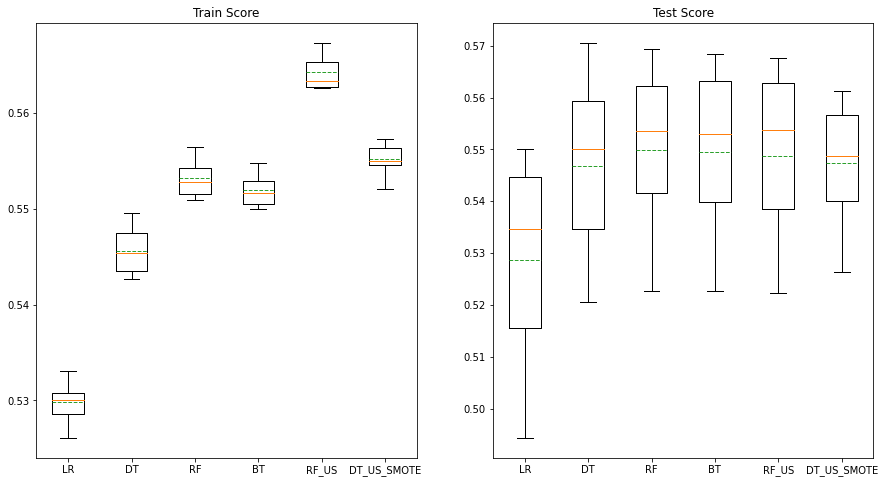

In [62]:
train_stats = cbook.boxplot_stats(train_scores, labels=labels)
test_stats = cbook.boxplot_stats(test_scores, labels=labels)
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 8))
ax[0].bxp(train_stats, showfliers=False, meanline=True, showmeans=True)
ax[0].set_title('Train Score')
ax[1].bxp(test_stats, showfliers=False, meanline=True, showmeans=True)
ax[1].set_title('Test Score')
plt.show()

In [68]:
import pickle
load = {'labels': labels,
        'train_scores': train_scores,
        'test_scores': test_scores}
with open('model_results.dump', 'wb') as f:
    pickle.dump(load, f)